In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
import seaborn as sns
from keras.optimizers import Adam
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

Using TensorFlow backend.
d:\anaconda\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\anaconda\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\anaconda\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\anaconda\envs\deeplearning\lib\site-packages\tensorflow\python

## Reading and analysing data

In [3]:

path = "D:/NLP_Project/Alzheimer-s-Disease-Prediction-using-NLP-master/cleaned_data.tsv"
df = pd.read_csv(path, sep="\t")



In [4]:
df

,Transcripts,AD
0,there's &um a young boy that's getting a cooki...,1
1,and it he's uh in bad shape because uh the thi...,1
2,and in the picture the mother is washing dishe...,1
3,and the dishes might get falled over if you don't,1
4,fell fall over there there if you don't get it,1
...,...,...
3267,the mother's standing there doing the dishes,0
3268,she's washing the dishes looking out the open ...,0
3269,and the water's runnin(g) down over the sink o...,0
3270,and <there are> [//] she's dryin(g) a dish,0


In [5]:
df.iloc[3271]

Transcripts    summer of the year
AD                              0
Name: 3271, dtype: object

In [83]:
len(df)

3272

Class 0 samples:  1676
Class 1 samples:  1596


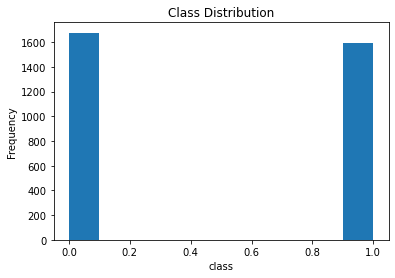

In [98]:
counts, bins = np.histogram(df['AD'])
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Class Distribution")
plt.xlabel('class')
plt.ylabel('Frequency')
print("Class 0 samples: ",len(df[df['AD']==0]))
print("Class 1 samples: ",len(df[df['AD']==1]))
plt.show()



## Preprocess data
1. Clean data
2. remove stop words
3. Apply Stemming (optional)
3. Apply lemmatization (Optional)

In [6]:
# clean data. Keep only english alphabets

In [8]:
import string

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
string_punctuation_1 = string.punctuation.replace(".","").replace("`","").replace("'","")
table_ = str.maketrans(string_punctuation_1, ' '*len(string_punctuation_1))
printable = set(string.printable)


def clean_data(text):
    
    sentence = text.lower()
    sentence_no_punct = sentence.translate(table_)
    space_remove = re.sub('\s+',' ', sentence_no_punct)
    return space_remove
    

In [9]:
df['Transcripts_cleaned'] = df['Transcripts'].apply(lambda row: clean_data(row) )

In [10]:
df['Transcripts_cleaned'].iloc[2051] , df['AD'].iloc[2051]

('and the little girl has pushed over the . chair stool with the boy that uh he that was reaching up to get the cookies you know it',
 1)

In [99]:
#stemming data (optional)

In [11]:
stemmer = SnowballStemmer('english')
def stem_words(text):
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [12]:
df['Transcripts_stem'] = df['Transcripts_cleaned'].apply(lambda row: stem_words(row))

In [13]:
df['Transcripts_stem']

0               there um a young boy that get a cooki jar
1        and it he uh in bad shape becaus uh the thing is
2       and in the pictur the mother is wash dish and ...
3           and the dish might get fall over if you don't
4          fell fall over there there if you don't get it
                              ...                        
3267                   the mother stand there do the dish
3268         she wash the dish look out the open window .
3269    and the water runnin g down over the sink on o...
3270                     and there are she dryin g a dish
3271                                   summer of the year
Name: Transcripts_stem, Length: 3272, dtype: object

In [ ]:
#Lemmatizing data (optional)

In [15]:
lemmatizer = WordNetLemmatizer() 

In [16]:
df['Transcripts_lem'] = df['Transcripts_cleaned'].apply(lambda row: " ".join([lemmatizer.lemmatize(i) for i in word_tokenize(row)]))

In [17]:
df['Transcripts_lem']

0       there 's um a young boy that 's getting a cook...
1       and it he 's uh in bad shape because uh the th...
2       and in the picture the mother is washing dish ...
3        and the dish might get falled over if you do n't
4         fell fall over there there if you do n't get it
                              ...                        
3267          the mother 's standing there doing the dish
3268    she 's washing the dish looking out the open w...
3269    and the water 's runnin g down over the sink o...
3270                  and there are she 's dryin g a dish
3271                                   summer of the year
Name: Transcripts_lem, Length: 3272, dtype: object

## TF-IDF approach

In [18]:
#transforming sentences to vectors


vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=5, max_df=0.9) 
X = vectorizer.fit_transform(df['Transcripts_cleaned'].tolist())

In [19]:
X.shape

(3272, 316)

In [20]:
#checking the weights assigned to each word

sorted([x for x in zip(vectorizer.get_feature_names(), vectorizer.idf_)], key=lambda x:x[1], reverse=True)

[('age', 7.301702805273125),
 ('anybody', 7.301702805273125),
 ('climbing', 7.301702805273125),
 ('curved', 7.301702805273125),
 ('daughter', 7.301702805273125),
 ('di', 7.301702805273125),
 ('dressed', 7.301702805273125),
 ('eat', 7.301702805273125),
 ('fairly', 7.301702805273125),
 ('giving', 7.301702805273125),
 ('handle', 7.301702805273125),
 ('head', 7.301702805273125),
 ('hit', 7.301702805273125),
 ('knows', 7.301702805273125),
 ('lip', 7.301702805273125),
 ('movement', 7.301702805273125),
 ('notice', 7.301702805273125),
 ('old', 7.301702805273125),
 ('outta', 7.301702805273125),
 ('overspilling', 7.301702805273125),
 ('pourin', 7.301702805273125),
 ('reason', 7.301702805273125),
 ('scene', 7.301702805273125),
 ('shocked', 7.301702805273125),
 ('sleeveless', 7.301702805273125),
 ('slight', 7.301702805273125),
 ('spilled', 7.301702805273125),
 ('splashin', 7.301702805273125),
 ('stealin', 7.301702805273125),
 ('tennis', 7.301702805273125),
 ('towel', 7.301702805273125),
 ('tumbles

In [21]:
X = X.toarray()
y= np.array(df['AD'].tolist())

In [22]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

In [23]:
models_f1 = []
models_f1.append((LogisticRegression()))
#models.append(('GSearch', LinearDiscriminantAnalysis()))
models_f1.append(( KNeighborsClassifier()))
models_f1.append((DecisionTreeClassifier()))
models_f1.append((MultinomialNB()))
models_f1.append((SVC(kernel="linear", C=0.1,probability=True)))
models_f1.append((RandomForestClassifier()))
models_f1.append((AdaBoostClassifier()))

LogisticRegression
****Results****
Accuracy: 68.5496%
****F1 score,Precision and recall****
f1_score: 0.6854778554778554 , Precison: 0.6854755999776232, Recall: 0.6854928947073962, Individual_f1: [0.68787879 0.68307692]
(array([0.6809816, 0.6899696]), array([0.68518519, 0.6858006 ]), array([0.68307692, 0.68787879]), array([324, 331], dtype=int64))
***confusion matrix****


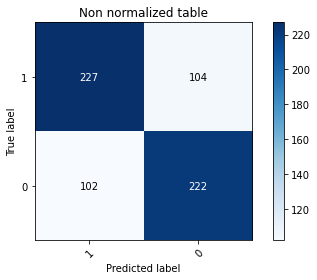

Log Loss: 0.5912699211672712
KNeighborsClassifier
****Results****
Accuracy: 71.2977%
****F1 score,Precision and recall****
f1_score: 0.7120582898404326 , Precison: 0.7146767294175288, Recall: 0.7124547760247659, Individual_f1: [0.7283237  0.69579288]
(array([0.73129252, 0.69806094]), array([0.66358025, 0.76132931]), array([0.69579288, 0.7283237 ]), array([324, 331], dtype=int64))
***confusion matrix****


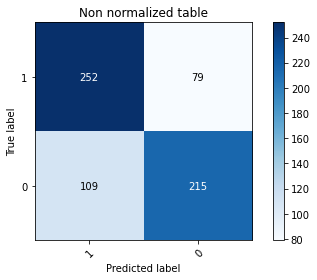

Log Loss: 2.05473574551026
DecisionTreeClassifier
****Results****
Accuracy: 83.9695%
****F1 score,Precision and recall****
f1_score: 0.8396886778599051 , Precison: 0.839687290221526, Recall: 0.8397252993174443, Individual_f1: [0.84066768 0.83870968]
(array([0.83486239, 0.8445122 ]), array([0.84259259, 0.83685801]), array([0.83870968, 0.84066768]), array([324, 331], dtype=int64))
***confusion matrix****


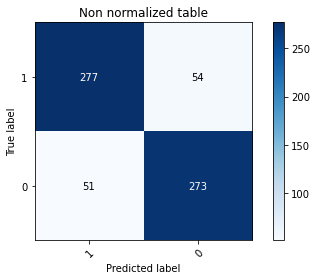

Log Loss: 1.9757199300323958
MultinomialNB
****Results****
Accuracy: 67.9389%
****F1 score,Precision and recall****
f1_score: 0.6778688524590164 , Precison: 0.6816286694335474, Recall: 0.6787326097497296, Individual_f1: [0.7       0.6557377]
(array([0.6993007 , 0.66395664]), array([0.61728395, 0.74018127]), array([0.6557377, 0.7      ]), array([324, 331], dtype=int64))
***confusion matrix****


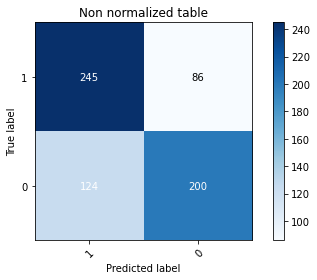

Log Loss: 0.5907658163829599
SVC
****Results****
Accuracy: 62.5954%
****F1 score,Precision and recall****
f1_score: 0.6028446199954957 , Precison: 0.6587676588396134, Recall: 0.6234474655924807, Individual_f1: [0.69864699 0.50704225]
(array([0.7283237 , 0.58921162]), array([0.38888889, 0.85800604]), array([0.50704225, 0.69864699]), array([324, 331], dtype=int64))
***confusion matrix****


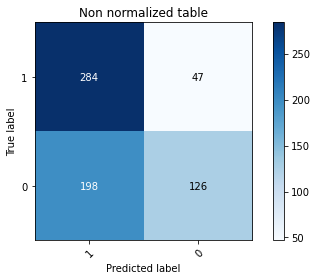

Log Loss: 0.6239462481623921
RandomForestClassifier
****Results****
Accuracy: 84.5802%
****F1 score,Precision and recall****
f1_score: 0.8458015267175573 , Precison: 0.8458981388236172, Recall: 0.8458981388236172, Individual_f1: [0.84580153 0.84580153]
(array([0.83685801, 0.85493827]), array([0.85493827, 0.83685801]), array([0.84580153, 0.84580153]), array([324, 331], dtype=int64))
***confusion matrix****


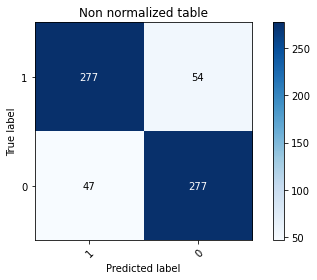

Log Loss: 0.36859770890198745
AdaBoostClassifier
****Results****
Accuracy: 63.9695%
****F1 score,Precision and recall****
f1_score: 0.6309189540236473 , Precison: 0.6574281680783922, Recall: 0.6414158367834097, Individual_f1: [0.57400722 0.68783069]
(array([0.60185185, 0.71300448]), array([0.80246914, 0.48036254]), array([0.68783069, 0.57400722]), array([324, 331], dtype=int64))
***confusion matrix****


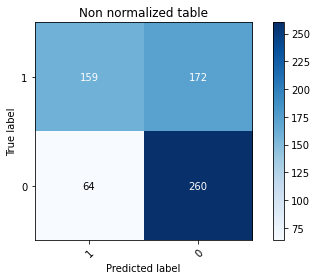

Log Loss: 0.6751519985292669


In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
for clf in models_f1:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    print('****F1 score,Precision and recall****')
    f1_score = sklearn.metrics.f1_score(y_test, train_predictions,average='macro')
    Precision = sklearn.metrics.precision_score(y_test, train_predictions,average='macro')
    Recall = sklearn.metrics.recall_score(y_test, train_predictions,average='macro')
    individual_f1 = sklearn.metrics.f1_score(y_test, train_predictions, average=None)
    print("f1_score: {} , Precison: {}, Recall: {}, Individual_f1: {}".format(f1_score,Precision,Recall,individual_f1))
    print(precision_recall_fscore_support(y_test, train_predictions, average=None, labels=df['AD'].unique()))
    print('***confusion matrix****')
    classes = df['AD'].unique()
    cm = confusion_matrix(y_test, train_predictions)
    fig, ax = plt.subplots()
    cmap=plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Non normalized table",
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    normalize = False
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

### Grid Search + SVM 

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.externals import joblib
svc = SVC(probability=True)
parameters = {'kernel':('linear','rbf'), 'C':[0.01, 10]}
model = GridSearchCV(svc,parameters)
model.fit(X_train, y_train)
print(model)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)
0.8259541984732824
[[272  59]
 [ 55 269]]
(array([0.83180428, 0.82012195]), array([0.82175227, 0.83024691]), array([0.82674772, 0.82515337]), array([331, 324], dtype=int64))


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       331
           1       0.82      0.83      0.83       324

    accuracy                           0.83       655
   macro avg       0.83      0.83      0.83       655
weighted avg       0.83      0.83      0.83       655



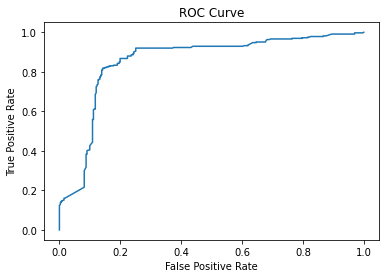

In [42]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

### Random Forest

In [43]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
print(model_rf)
y_pred = model_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))
print(classification_report(y_test,y_pred))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.8320610687022901
[[270  61]
 [ 49 275]]
(array([0.84639498, 0.81845238]), array([0.81570997, 0.84876543]), array([0.83076923, 0.83333333]), array([331, 324], dtype=int64))
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       331
           1       0.82      0.85      0.83       324

    accuracy                           0.83       655
   macro avg       0.83      0.83      0.83       655
weighte

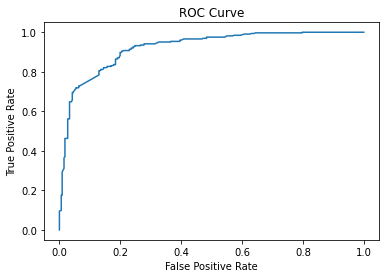

In [44]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model_rf.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

### Decision Tree 

In [45]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
print(model_dt)
y_pred = model_dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)

labels = [0, 1]
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average=None, labels= labels))
print(classification_report(y_test,y_pred))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.8351145038167939
[[276  55]
 [ 53 271]]
(array([0.83890578, 0.83128834]), array([0.83383686, 0.83641975]), array([0.83636364, 0.83384615]), array([331, 324], dtype=int64))
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       331
           1       0.83      0.84      0.83       324

    accuracy                           0.84       655
   macro avg       0.84      0.84      0.84       655
weighted avg       0.84      0.84      0.84       655



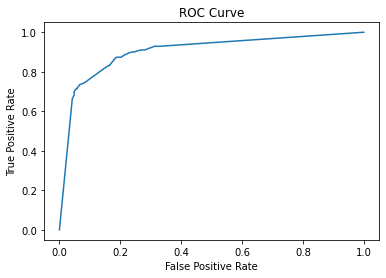

In [46]:
from sklearn.metrics import roc_curve , roc_auc_score
y_probas = model_dt.predict_proba(X_test)[:,1]
#skplt.metrics.plot_roc_curve(y_test, y_probas)
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

## Deep Learning Approach

In [47]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout,Conv1D, Flatten, MaxPooling1D, Dense, LSTM,Conv1D,MaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.constraints import maxnorm
from keras.preprocessing import sequence
from keras.callbacks import History
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
#Splitting data

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(df['Transcripts_cleaned'], df['AD'], test_size = 0.1, random_state = 0)

In [49]:
#Tokenizing sentences

tokenizer = Tokenizer(num_words = 2500)
tokenizer.fit_on_texts(X_seq_train)

Xwords_train = tokenizer.texts_to_sequences(X_seq_train)
Xwords_test = tokenizer.texts_to_sequences(X_seq_test)

In [50]:
#Padding the sentence sequences

max_review_length = 100
Xwords_train = sequence.pad_sequences(Xwords_train, maxlen=max_review_length)
Xwords_test = sequence.pad_sequences(Xwords_test, maxlen=max_review_length)

In [51]:
print(Xwords_train.shape)
print(Xwords_test.shape)
print(y_seq_train.shape)
print(y_seq_test.shape)

(2944, 100)
(328, 100)
(2944,)
(328,)


In [52]:
vocab = len(tokenizer.word_index) + 1   # Add one for the zero indexing
vocab

1098

In [53]:
#setting history parameter to record accuracy and loss info of model

history = History()

### LSTM Model

In [54]:

model = Sequential()
model.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          109800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 227,177
Trainable params: 227,177
Non-trainable params: 0
_________________________________________________________________
None

Train on 2649 samples, validate on 295 samples
Epoch 1/50
2649/2649 [==============================] - 27s 10ms/step - loss: 0.6897 - accuracy: 0.5428 - val_loss: 0.6809 - val_accuracy: 0.6068
Epoch 2/50
2649/2649 [==============================] - 3s 1ms/step - loss: 0.6725 - 

2649/2649 [==============================] - 3s 1ms/step - loss: 0.1458 - accuracy: 0.9366 - val_loss: 0.5955 - val_accuracy: 0.8508
Epoch 49/50
2649/2649 [==============================] - 2s 795us/step - loss: 0.1452 - accuracy: 0.9370 - val_loss: 0.6537 - val_accuracy: 0.8576
Epoch 50/50
2649/2649 [==============================] - 2s 883us/step - loss: 0.1465 - accuracy: 0.9370 - val_loss: 0.5962 - val_accuracy: 0.8576


In [56]:
#evaluating model on test data

eval_list = model.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

328/328 [==============================] - 1s 4ms/step
Test Loss:  0.5132803451724168
Test Accuracy:  0.8414633870124817


In [67]:
model.save('saved_models/model_lstm.h5')

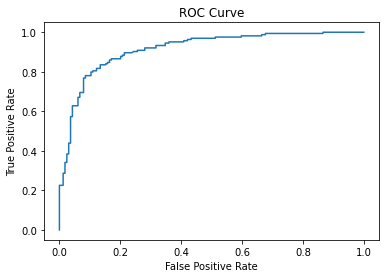

In [62]:
y_pred_probas = model.predict(Xwords_test)
y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

In [64]:
#predicting classes on test data

y_pred = model.predict_classes(Xwords_test)
y_pred = [i[0] for i in y_pred]

In [65]:
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[137  27]
 [ 25 139]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       164
           1       0.84      0.85      0.84       164

    accuracy                           0.84       328
   macro avg       0.84      0.84      0.84       328
weighted avg       0.84      0.84      0.84       328



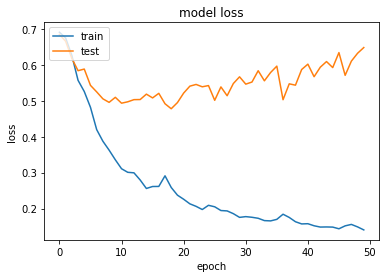

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

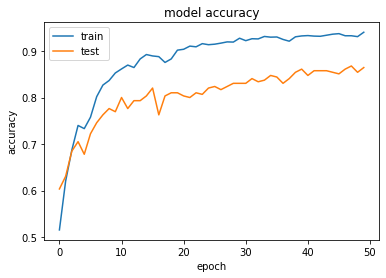

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Bidirectional LSTM Model

In [66]:

model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model_bilstm.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_bilstm.summary())

model_bilstm.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          109800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 344,553
Trainable params: 344,553
Non-trainable params: 0
_________________________________________________________________
None
Train on 2649 samples, validate on 295 samples
Epoch 1/50
2649/2649 [==============================] - 7s 2ms/step - loss: 0.6920 - accuracy: 0.5247 - val_loss: 0.6905 - val_accuracy: 0.5254
Epoch 2/50
2649/2649 [==============================] - 4s 2ms/step - loss: 0.6809 - accuracy: 0.6104 - val_loss: 0.6690 - val_accuracy: 0.6373
Epoch 3/50
2649/2649 [================

In [69]:
eval_list = model_bilstm.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

328/328 [==============================] - 1s 4ms/step
Test Loss:  0.5430982607166942
Test Accuracy:  0.8567073345184326


In [70]:
model_bilstm.save('saved_models/model_bilstm.h5')

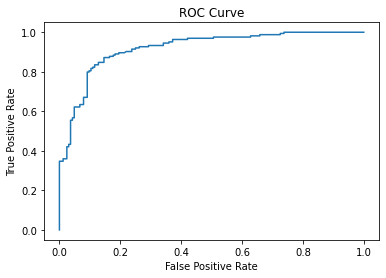

In [71]:
y_pred_probas = model_bilstm.predict(Xwords_test)
y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

In [72]:
y_pred = model_bilstm.predict_classes(Xwords_test)
y_pred = [i[0] for i in y_pred]

In [73]:
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[138  26]
 [ 21 143]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       164
           1       0.85      0.87      0.86       164

    accuracy                           0.86       328
   macro avg       0.86      0.86      0.86       328
weighted avg       0.86      0.86      0.86       328



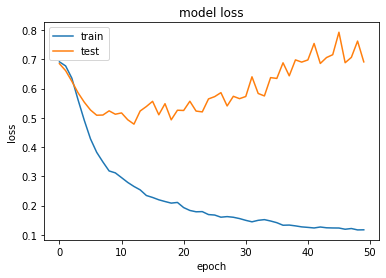

In [79]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

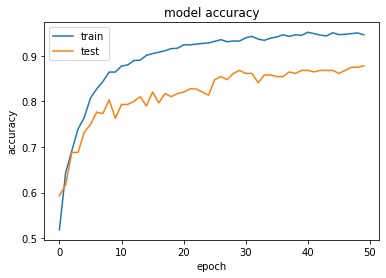

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN-LSTM Model

In [75]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocab, 100, input_length=100))
    model_conv.add(Dropout(0.1))
    model_conv.add(Conv1D(32, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(64))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model_conv


In [76]:
model_conv_1 = create_conv_model()
model_conv_1.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)


Train on 2649 samples, validate on 295 samples
Epoch 1/50
2649/2649 [==============================] - 15s 6ms/step - loss: 0.6928 - accuracy: 0.5028 - val_loss: 0.6896 - val_accuracy: 0.5797
Epoch 2/50
2649/2649 [==============================] - 1s 459us/step - loss: 0.6876 - accuracy: 0.5557 - val_loss: 0.6833 - val_accuracy: 0.6339
Epoch 3/50
2649/2649 [==============================] - 1s 428us/step - loss: 0.6730 - accuracy: 0.6636 - val_loss: 0.6639 - val_accuracy: 0.6542
Epoch 4/50
2649/2649 [==============================] - 1s 309us/step - loss: 0.6272 - accuracy: 0.6942 - val_loss: 0.6160 - val_accuracy: 0.6847
Epoch 5/50
2649/2649 [==============================] - 1s 372us/step - loss: 0.5431 - accuracy: 0.7274 - val_loss: 0.5679 - val_accuracy: 0.7119
Epoch 6/50
2649/2649 [==============================] - 1s 414us/step - loss: 0.4623 - accuracy: 0.7682 - val_loss: 0.5291 - val_accuracy: 0.7492
Epoch 7/50
2649/2649 [==============================] - 1s 460us/step - loss:

In [77]:
#model_conv_1.evaluate(Xwords_test,y_seq_test)
eval_list = model_conv_1.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

328/328 [==============================] - 1s 3ms/step
Test Loss:  0.48141532409481885
Test Accuracy:  0.9115853905677795


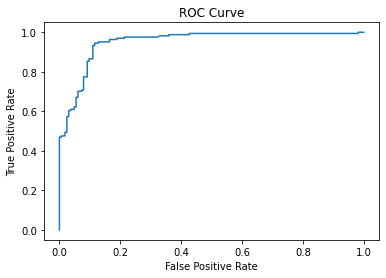

In [79]:
y_pred_probas = model_conv_1.predict(Xwords_test)
y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

In [80]:
y_pred = model_conv_1.predict_classes(Xwords_test)
y_pred = [i[0] for i in y_pred]
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[144  20]
 [  9 155]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       164
           1       0.89      0.95      0.91       164

    accuracy                           0.91       328
   macro avg       0.91      0.91      0.91       328
weighted avg       0.91      0.91      0.91       328



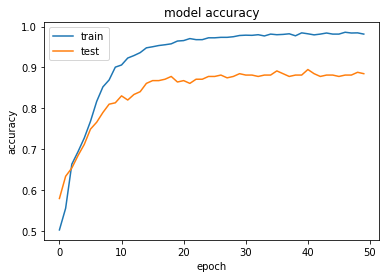

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

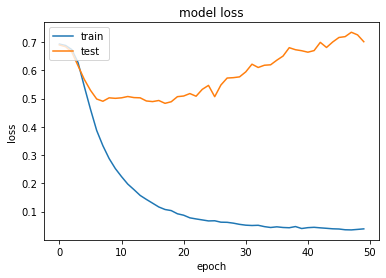

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()